In [89]:
# Lots to import!
import time
import numpy as np
import pandas as pd
import os
from bs4 import BeautifulSoup
import requests
import csv
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import date
from functools import reduce
from datetime import datetime
from collections import Counter
from dateutil.rrule import rrule, DAILY
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Team
from basketball_reference_web_scraper.data import Outcome
from basketball_reference_web_scraper.data import Position

In [104]:
#This function scrapes the leader stats similar to the "leader_scrape_function", however it stores
#for every player in each game, exactly what portion of his team's
#points, rebounds, assists, and blocks were his contribution, and returns it in lists, along with an average, 
#all the while accounting for wins or losses.


def proportional_scrape(start_month, start_day, start_year, end_month, end_day, end_year):

    t0 = time.time() # Start timer to keep track how long code runs. Usually takes 1-5 minutes for one season.
                    
    player_dict_w={}
    player_dict_w_reb={}
    player_dict_w_assist={}
    player_dict_w_blk={}

    player_dict_l={}
    player_dict_l_reb={}
    player_dict_l_assist={}
    player_dict_l_blk={}

    # Sets the start and end date (including both ends) in format (YYYY, MM, DD), from 1999-2000 season onwards.
    a = date(start_year, start_month, start_day)
    b = date(end_year, end_month, end_day)

    for dt in rrule(DAILY, dtstart=a, until=b): # iterate over every day in the range

        monthh=dt.strftime("%m")
        dayy=dt.strftime("%d")
        yearr=dt.strftime("%Y")
        bs=client.player_box_scores(day=dayy, month=monthh, year=yearr) # Where the scraping occurs, using imported library
        df=pd.DataFrame(bs) # creates DataFrame from list of dictionaries; should include box score for that day

        if df.empty: # if no game was played that day
            print ("no games played on",monthh,dayy,yearr)
            continue  # we can jump to the next day if no games were played this day

        df=df.set_index("name")
        df['points']=df['made_free_throws']+2*(df['made_field_goals']-df['made_three_point_field_goals'])+3*df['made_three_point_field_goals'] #calculates points from shots made
        df['rebounds']=df['offensive_rebounds']+df["defensive_rebounds"] #calculates rebounds by adding both ORBs and DRBs
        df = df.astype({"outcome": str,'team':str}) #converts outcome into string so we can filter by win vs loss.

        for team in set(df['team']):  #for each team that on this day

            df_new = df[df['team']==team] #new df just for one team at a time
            tot_points = df_new['points'].sum()
            tot_rebounds = df_new['rebounds'].sum()
            tot_assists = df_new['assists'].sum()
            if df_new['outcome'].iloc[0]=="Outcome.WIN":
                for player in df_new.index:
                    #Add the proportions of points scored by player for team this day
                    if player in player_dict_w:
                        player_dict_w[player].append(df_new['points'][player]/tot_points)
                    if player not in player_dict_w:
                        player_dict_w[player]=[df_new['points'][player]/tot_points]
                    #Add the proportions of rebounds scored by player for team this day
                    if player in player_dict_w_reb:
                        player_dict_w_reb[player].append(df_new['rebounds'][player]/tot_rebounds)
                    if player not in player_dict_w_reb:
                        player_dict_w_reb[player]=[df_new['rebounds'][player]/tot_rebounds]
                    #Add the proportions of assists scored by player for team this day
                    if player in player_dict_w_assist:
                        player_dict_w_assist[player].append(df_new['assists'][player]/tot_assists)
                    if player not in player_dict_w_assist:
                        player_dict_w_assist[player]=[df_new['assists'][player]/tot_assists]
                    #Add the proportions of blocks scored by player for team this day
                    if player in player_dict_w_blk:
                        player_dict_w_blk[player].append(df_new['assists'][player]/tot_assists)
                    if player not in player_dict_w_blk:
                        player_dict_w_blk[player]=[df_new['assists'][player]/tot_assists]
            if df_new['outcome'].iloc[0]=="Outcome.LOSS":
                for player in df_new.index:
                    #Add the proportions of points scored by player for team this day
                    if player in player_dict_l:
                        player_dict_l[player].append(df_new['points'][player]/tot_points)
                    if player not in player_dict_l:
                        player_dict_l[player]=[df_new['points'][player]/tot_points]
                    #Add the proportions of rebounds scored by player for team this day
                    if player in player_dict_l_reb:
                        player_dict_l_reb[player].append(df_new['rebounds'][player]/tot_rebounds)
                    if player not in player_dict_l_reb:
                        player_dict_l_reb[player]=[df_new['rebounds'][player]/tot_rebounds]
                    #Add the proportions of assists scored by player for team this day
                    if player in player_dict_l_assist:
                        player_dict_l_assist[player].append(df_new['assists'][player]/tot_assists)
                    if player not in player_dict_l_assist:
                        player_dict_l_assist[player]=[df_new['assists'][player]/tot_assists]
                    #Add the proportions of blocks scored by player for team this day
                    if player in player_dict_l_blk:
                        player_dict_l_blk[player].append(df_new['assists'][player]/tot_assists)
                    if player not in player_dict_l_blk:
                        player_dict_l_blk[player]=[df_new['assists'][player]/tot_assists]

        print ("Done scraping day:",monthh,dayy,yearr)


    t1 = time.time() # end timer and print total time
    total = t1-t0
    print ("total time scraping:",total,"seconds")

    lead_proportional = pd.DataFrame([player_dict_w, player_dict_w_reb, player_dict_w_assist,player_dict_w_blk,
                  player_dict_l, player_dict_l_reb, player_dict_l_assist,player_dict_l_blk]).T
    lead_proportional.columns=['point_spread_w','rebound_spread_w','assist_spread_w','block_spread_w',
            'point_spread_l','rebound_spread_l','assist_spread_l','block_spread_l']
    lead_proportional['avg_pts_spread_w']=lead_proportional['point_spread_w'].apply(np.mean)
    lead_proportional['avg_reb_spread_w']=lead_proportional['rebound_spread_w'].apply(np.mean)
    lead_proportional['avg_ast_spread_w']=lead_proportional['assist_spread_w'].apply(np.mean)
    lead_proportional['avg_blk_spread_w']=lead_proportional['block_spread_w'].apply(np.mean)
    lead_proportional['avg_combined_spread_w']=lead_proportional[['avg_pts_spread_w','avg_reb_spread_w','avg_ast_spread_w']].sum(axis=1)
    lead_proportional=lead_proportional.sort_values("avg_combined_spread_w",ascending=False)
    return (lead_proportional).fillna(0)
    
    
proportional_scrape(10, 18, 2018, 10, 20, 2018)   

Done scraping day: 10 18 2018
Done scraping day: 10 19 2018
Done scraping day: 10 20 2018
total time scraping: 1.3615021705627441 seconds


,point_spread_w,rebound_spread_w,assist_spread_w,block_spread_w,point_spread_l,rebound_spread_l,assist_spread_l,block_spread_l,avg_pts_spread_w,avg_reb_spread_w,avg_ast_spread_w,avg_blk_spread_w,avg_combined_spread_w
Nikola Jokic,[0.29411764705882354],[0.2037037037037037],[0.39285714285714285],[0.39285714285714285],0,0,0,0,0.294118,0.203704,0.392857,0.392857,0.890678
Chris Paul,[0.22580645161290322],[0.12962962962962962],[0.45454545454545453],[0.45454545454545453],0,0,0,0,0.225806,0.129630,0.454545,0.454545,0.809982
Kevin Durant,[0.3064516129032258],[0.20930232558139536],[0.25925925925925924],[0.25925925925925924],0,0,0,0,0.306452,0.209302,0.259259,0.259259,0.775013
Blake Griffin,[0.2796610169491525],[0.24489795918367346],[0.23809523809523808],[0.23809523809523808],0,0,0,0,0.279661,0.244898,0.238095,0.238095,0.762654
Giannis Antetokounmpo,[0.22033898305084745],[0.3],[0.18518518518518517],[0.18518518518518517],0,0,0,0,0.220339,0.300000,0.185185,0.185185,0.705524
Kyle Lowry,"[0.13274336283185842, 0.23931623931623933]","[0.12244897959183673, 0.057692307692307696]","[0.25, 0.5714285714285714]","[0.25, 0.5714285714285714]",0,0,0,0,0.186030,0.090071,0.410714,0.410714,0.686815
Tobias Harris,[0.24074074074074073],[0.22916666666666666],[0.19047619047619047],[0.19047619047619047],0,0,0,0,0.240741,0.229167,0.190476,0.190476,0.660384
James Harden,[0.2903225806451613],[0.12962962962962962],[0.22727272727272727],[0.22727272727272727],0,0,0,0,0.290323,0.129630,0.227273,0.227273,0.647225
Stephen Curry,[0.25],[0.09302325581395349],[0.2962962962962963],[0.2962962962962963],0,0,0,0,0.250000,0.093023,0.296296,0.296296,0.639320
Kawhi Leonard,[0.2743362831858407],[0.20408163265306123],[0.125],[0.125],0,0,0,0,0.274336,0.204082,0.125000,0.125000,0.603418


In [113]:
#WRITE ALL SEASON LEADERS TO CSV, takes about 30-60 minutes to run. Remove """ to run code.

dates=[[11, 6, 1987, 4, 24, 1988],[11, 4, 1988, 4, 23, 1989],
       [11, 3, 1989, 4, 22, 1990] ,[11, 2, 1990, 4, 21, 1991] ,
       [11, 1, 1991, 4, 19, 1992] ,[11, 6, 1992, 4, 25, 1993] ,
       [11, 5, 1993, 4, 24, 1994] ,[11, 4, 1994, 4, 23, 1995] ,
       [11, 3, 1995, 4, 21, 1996] ,[11, 1, 1996, 4, 20, 1997] ,
       [10, 31, 1997, 4, 19, 1998],[2, 5, 1999, 5, 5, 1999],
       [11, 2, 1999, 4, 19, 2000] ,[10, 31, 2000, 4, 18, 2001],
       [10, 30, 2001, 4, 17, 2002], [10, 29, 2002, 4, 16, 2003],
       [10, 28, 2003, 4, 14, 2004] ,[11, 2, 2004, 4, 20, 2005] ,
       [11, 1, 2005, 4, 19, 2006] ,[10, 31, 2006, 4, 18, 2007] ,
       [10, 30, 2007, 4, 16, 2008] ,[10, 28, 2008, 4, 16, 2009] ,
       [10, 27, 2009, 4, 14, 2010] ,[10, 26, 2010, 4, 13, 2011] ,
       [11, 25, 2011, 4, 2, 2012] ,[10, 30, 2012, 4, 17, 2013] ,
       [10, 29, 2013, 4, 16, 2014] ,[10, 28, 2014, 4, 15, 2015] ,
       [10, 27, 2015, 4, 13, 2016] ,[10, 25, 2016, 4, 12, 2017] ,
       [10, 17, 2017, 4, 11, 2018] ,[10, 16, 2018, 3, 11, 2019]]

"""for season_dates in dates[12:]:
    df = proportional_scrape(season_dates[0], season_dates[1], season_dates[2], season_dates[3], season_dates[4], season_dates[5])
    outname = f"season_leaders_proportional_{season_dates[5]}.csv"
    outdir = './season_leaders_proportional'
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    fullname = os.path.join(outdir, outname)    
    df.to_csv(fullname)"""


Done scraping day: 11 02 1999
Done scraping day: 11 03 1999
Done scraping day: 11 04 1999
Done scraping day: 11 05 1999
Done scraping day: 11 06 1999
Done scraping day: 11 07 1999
Done scraping day: 11 08 1999
Done scraping day: 11 09 1999
Done scraping day: 11 10 1999
Done scraping day: 11 11 1999
Done scraping day: 11 12 1999
Done scraping day: 11 13 1999
Done scraping day: 11 14 1999
Done scraping day: 11 15 1999
Done scraping day: 11 16 1999
Done scraping day: 11 17 1999
Done scraping day: 11 18 1999
Done scraping day: 11 19 1999
Done scraping day: 11 20 1999
Done scraping day: 11 21 1999
Done scraping day: 11 22 1999
Done scraping day: 11 23 1999
Done scraping day: 11 24 1999
Done scraping day: 11 25 1999
Done scraping day: 11 26 1999
Done scraping day: 11 27 1999
Done scraping day: 11 28 1999
Done scraping day: 11 29 1999
Done scraping day: 11 30 1999
Done scraping day: 12 01 1999
Done scraping day: 12 02 1999
Done scraping day: 12 03 1999
Done scraping day: 12 04 1999
Done scrap

no games played on 02 10 2001
no games played on 02 11 2001
no games played on 02 12 2001
Done scraping day: 02 13 2001
Done scraping day: 02 14 2001
Done scraping day: 02 15 2001
Done scraping day: 02 16 2001
Done scraping day: 02 17 2001
Done scraping day: 02 18 2001
Done scraping day: 02 19 2001
Done scraping day: 02 20 2001
Done scraping day: 02 21 2001
Done scraping day: 02 22 2001
Done scraping day: 02 23 2001
Done scraping day: 02 24 2001
Done scraping day: 02 25 2001
Done scraping day: 02 26 2001
Done scraping day: 02 27 2001
Done scraping day: 02 28 2001
Done scraping day: 03 01 2001
Done scraping day: 03 02 2001
Done scraping day: 03 03 2001
Done scraping day: 03 04 2001
Done scraping day: 03 05 2001
Done scraping day: 03 06 2001
Done scraping day: 03 07 2001
Done scraping day: 03 08 2001
Done scraping day: 03 09 2001
Done scraping day: 03 10 2001
Done scraping day: 03 11 2001
Done scraping day: 03 12 2001
Done scraping day: 03 13 2001
Done scraping day: 03 14 2001
Done scrap

Done scraping day: 11 30 2002
Done scraping day: 12 01 2002
Done scraping day: 12 02 2002
Done scraping day: 12 03 2002
Done scraping day: 12 04 2002
Done scraping day: 12 05 2002
Done scraping day: 12 06 2002
Done scraping day: 12 07 2002
Done scraping day: 12 08 2002
Done scraping day: 12 09 2002
Done scraping day: 12 10 2002
Done scraping day: 12 11 2002
Done scraping day: 12 12 2002
Done scraping day: 12 13 2002
Done scraping day: 12 14 2002
Done scraping day: 12 15 2002
Done scraping day: 12 16 2002
Done scraping day: 12 17 2002
Done scraping day: 12 18 2002
Done scraping day: 12 19 2002
Done scraping day: 12 20 2002
Done scraping day: 12 21 2002
Done scraping day: 12 22 2002
Done scraping day: 12 23 2002
no games played on 12 24 2002
Done scraping day: 12 25 2002
Done scraping day: 12 26 2002
Done scraping day: 12 27 2002
Done scraping day: 12 28 2002
Done scraping day: 12 29 2002
Done scraping day: 12 30 2002
Done scraping day: 12 31 2002
Done scraping day: 01 01 2003
Done scrap

Done scraping day: 03 10 2004
Done scraping day: 03 11 2004
Done scraping day: 03 12 2004
Done scraping day: 03 13 2004
Done scraping day: 03 14 2004
Done scraping day: 03 15 2004
Done scraping day: 03 16 2004
Done scraping day: 03 17 2004
Done scraping day: 03 18 2004
Done scraping day: 03 19 2004
Done scraping day: 03 20 2004
Done scraping day: 03 21 2004
Done scraping day: 03 22 2004
Done scraping day: 03 23 2004
Done scraping day: 03 24 2004
Done scraping day: 03 25 2004
Done scraping day: 03 26 2004
Done scraping day: 03 27 2004
Done scraping day: 03 28 2004
Done scraping day: 03 29 2004
Done scraping day: 03 30 2004
Done scraping day: 03 31 2004
Done scraping day: 04 01 2004
Done scraping day: 04 02 2004
Done scraping day: 04 03 2004
Done scraping day: 04 04 2004
Done scraping day: 04 05 2004
Done scraping day: 04 06 2004
Done scraping day: 04 07 2004
Done scraping day: 04 08 2004
Done scraping day: 04 09 2004
Done scraping day: 04 10 2004
Done scraping day: 04 11 2004
Done scrap

Done scraping day: 01 04 2006
Done scraping day: 01 05 2006
Done scraping day: 01 06 2006
Done scraping day: 01 07 2006
Done scraping day: 01 08 2006
Done scraping day: 01 09 2006
Done scraping day: 01 10 2006
Done scraping day: 01 11 2006
Done scraping day: 01 12 2006
Done scraping day: 01 13 2006
Done scraping day: 01 14 2006
Done scraping day: 01 15 2006
Done scraping day: 01 16 2006
Done scraping day: 01 17 2006
Done scraping day: 01 18 2006
Done scraping day: 01 19 2006
Done scraping day: 01 20 2006
Done scraping day: 01 21 2006
Done scraping day: 01 22 2006
Done scraping day: 01 23 2006
Done scraping day: 01 24 2006
Done scraping day: 01 25 2006
Done scraping day: 01 26 2006
Done scraping day: 01 27 2006
Done scraping day: 01 28 2006
Done scraping day: 01 29 2006
Done scraping day: 01 30 2006
Done scraping day: 01 31 2006
Done scraping day: 02 01 2006
Done scraping day: 02 02 2006
Done scraping day: 02 03 2006
Done scraping day: 02 04 2006
Done scraping day: 02 05 2006
Done scrap

Done scraping day: 04 15 2007
Done scraping day: 04 16 2007
Done scraping day: 04 17 2007
Done scraping day: 04 18 2007
total time scraping: 190.86736917495728 seconds
Done scraping day: 10 30 2007
Done scraping day: 10 31 2007
Done scraping day: 11 01 2007
Done scraping day: 11 02 2007
Done scraping day: 11 03 2007
Done scraping day: 11 04 2007
Done scraping day: 11 05 2007
Done scraping day: 11 06 2007
Done scraping day: 11 07 2007
Done scraping day: 11 08 2007
Done scraping day: 11 09 2007
Done scraping day: 11 10 2007
Done scraping day: 11 11 2007
Done scraping day: 11 12 2007
Done scraping day: 11 13 2007
Done scraping day: 11 14 2007
Done scraping day: 11 15 2007
Done scraping day: 11 16 2007
Done scraping day: 11 17 2007
Done scraping day: 11 18 2007
Done scraping day: 11 19 2007
Done scraping day: 11 20 2007
Done scraping day: 11 21 2007
no games played on 11 22 2007
Done scraping day: 11 23 2007
Done scraping day: 11 24 2007
Done scraping day: 11 25 2007
Done scraping day: 11 

Done scraping day: 02 01 2009
Done scraping day: 02 02 2009
Done scraping day: 02 03 2009
Done scraping day: 02 04 2009
Done scraping day: 02 05 2009
Done scraping day: 02 06 2009
Done scraping day: 02 07 2009
Done scraping day: 02 08 2009
Done scraping day: 02 09 2009
Done scraping day: 02 10 2009
Done scraping day: 02 11 2009
Done scraping day: 02 12 2009
no games played on 02 13 2009
no games played on 02 14 2009
no games played on 02 15 2009
no games played on 02 16 2009
Done scraping day: 02 17 2009
Done scraping day: 02 18 2009
Done scraping day: 02 19 2009
Done scraping day: 02 20 2009
Done scraping day: 02 21 2009
Done scraping day: 02 22 2009
Done scraping day: 02 23 2009
Done scraping day: 02 24 2009
Done scraping day: 02 25 2009
Done scraping day: 02 26 2009
Done scraping day: 02 27 2009
Done scraping day: 02 28 2009
Done scraping day: 03 01 2009
Done scraping day: 03 02 2009
Done scraping day: 03 03 2009
Done scraping day: 03 04 2009
Done scraping day: 03 05 2009
Done scrap

Done scraping day: 11 20 2010
Done scraping day: 11 21 2010
Done scraping day: 11 22 2010
Done scraping day: 11 23 2010
Done scraping day: 11 24 2010
Done scraping day: 11 25 2010
Done scraping day: 11 26 2010
Done scraping day: 11 27 2010
Done scraping day: 11 28 2010
Done scraping day: 11 29 2010
Done scraping day: 11 30 2010
Done scraping day: 12 01 2010
Done scraping day: 12 02 2010
Done scraping day: 12 03 2010
Done scraping day: 12 04 2010
Done scraping day: 12 05 2010
Done scraping day: 12 06 2010
Done scraping day: 12 07 2010
Done scraping day: 12 08 2010
Done scraping day: 12 09 2010
Done scraping day: 12 10 2010
Done scraping day: 12 11 2010
Done scraping day: 12 12 2010
Done scraping day: 12 13 2010
Done scraping day: 12 14 2010
Done scraping day: 12 15 2010
Done scraping day: 12 16 2010
Done scraping day: 12 17 2010
Done scraping day: 12 18 2010
Done scraping day: 12 19 2010
Done scraping day: 12 20 2010
Done scraping day: 12 21 2010
Done scraping day: 12 22 2010
Done scrap

Done scraping day: 03 31 2012
Done scraping day: 04 01 2012
Done scraping day: 04 02 2012
total time scraping: 132.99858593940735 seconds
Done scraping day: 10 30 2012
Done scraping day: 10 31 2012
Done scraping day: 11 01 2012
Done scraping day: 11 02 2012
Done scraping day: 11 03 2012
Done scraping day: 11 04 2012
Done scraping day: 11 05 2012
Done scraping day: 11 06 2012
Done scraping day: 11 07 2012
Done scraping day: 11 08 2012
Done scraping day: 11 09 2012
Done scraping day: 11 10 2012
Done scraping day: 11 11 2012
Done scraping day: 11 12 2012
Done scraping day: 11 13 2012
Done scraping day: 11 14 2012
Done scraping day: 11 15 2012
Done scraping day: 11 16 2012
Done scraping day: 11 17 2012
Done scraping day: 11 18 2012
Done scraping day: 11 19 2012
Done scraping day: 11 20 2012
Done scraping day: 11 21 2012
no games played on 11 22 2012
Done scraping day: 11 23 2012
Done scraping day: 11 24 2012
Done scraping day: 11 25 2012
Done scraping day: 11 26 2012
Done scraping day: 11 

Done scraping day: 02 03 2014
Done scraping day: 02 04 2014
Done scraping day: 02 05 2014
Done scraping day: 02 06 2014
Done scraping day: 02 07 2014
Done scraping day: 02 08 2014
Done scraping day: 02 09 2014
Done scraping day: 02 10 2014
Done scraping day: 02 11 2014
Done scraping day: 02 12 2014
Done scraping day: 02 13 2014
no games played on 02 14 2014
no games played on 02 15 2014
no games played on 02 16 2014
no games played on 02 17 2014
Done scraping day: 02 18 2014
Done scraping day: 02 19 2014
Done scraping day: 02 20 2014
Done scraping day: 02 21 2014
Done scraping day: 02 22 2014
Done scraping day: 02 23 2014
Done scraping day: 02 24 2014
Done scraping day: 02 25 2014
Done scraping day: 02 26 2014
Done scraping day: 02 27 2014
Done scraping day: 02 28 2014
Done scraping day: 03 01 2014
Done scraping day: 03 02 2014
Done scraping day: 03 03 2014
Done scraping day: 03 04 2014
Done scraping day: 03 05 2014
Done scraping day: 03 06 2014
Done scraping day: 03 07 2014
Done scrap

Done scraping day: 11 23 2015
Done scraping day: 11 24 2015
Done scraping day: 11 25 2015
no games played on 11 26 2015
Done scraping day: 11 27 2015
Done scraping day: 11 28 2015
Done scraping day: 11 29 2015
Done scraping day: 11 30 2015
Done scraping day: 12 01 2015
Done scraping day: 12 02 2015
Done scraping day: 12 03 2015
Done scraping day: 12 04 2015
Done scraping day: 12 05 2015
Done scraping day: 12 06 2015
Done scraping day: 12 07 2015
Done scraping day: 12 08 2015
Done scraping day: 12 09 2015
Done scraping day: 12 10 2015
Done scraping day: 12 11 2015
Done scraping day: 12 12 2015
Done scraping day: 12 13 2015
Done scraping day: 12 14 2015
Done scraping day: 12 15 2015
Done scraping day: 12 16 2015
Done scraping day: 12 17 2015
Done scraping day: 12 18 2015
Done scraping day: 12 19 2015
Done scraping day: 12 20 2015
Done scraping day: 12 21 2015
Done scraping day: 12 22 2015
Done scraping day: 12 23 2015
no games played on 12 24 2015
Done scraping day: 12 25 2015
Done scrap

Done scraping day: 03 03 2017
Done scraping day: 03 04 2017
Done scraping day: 03 05 2017
Done scraping day: 03 06 2017
Done scraping day: 03 07 2017
Done scraping day: 03 08 2017
Done scraping day: 03 09 2017
Done scraping day: 03 10 2017
Done scraping day: 03 11 2017
Done scraping day: 03 12 2017
Done scraping day: 03 13 2017
Done scraping day: 03 14 2017
Done scraping day: 03 15 2017
Done scraping day: 03 16 2017
Done scraping day: 03 17 2017
Done scraping day: 03 18 2017
Done scraping day: 03 19 2017
Done scraping day: 03 20 2017
Done scraping day: 03 21 2017
Done scraping day: 03 22 2017
Done scraping day: 03 23 2017
Done scraping day: 03 24 2017
Done scraping day: 03 25 2017
Done scraping day: 03 26 2017
Done scraping day: 03 27 2017
Done scraping day: 03 28 2017
Done scraping day: 03 29 2017
Done scraping day: 03 30 2017
Done scraping day: 03 31 2017
Done scraping day: 04 01 2017
Done scraping day: 04 02 2017
Done scraping day: 04 03 2017
Done scraping day: 04 04 2017
Done scrap

Done scraping day: 12 07 2018
Done scraping day: 12 08 2018
Done scraping day: 12 09 2018
Done scraping day: 12 10 2018
Done scraping day: 12 11 2018
Done scraping day: 12 12 2018
Done scraping day: 12 13 2018
Done scraping day: 12 14 2018
Done scraping day: 12 15 2018
Done scraping day: 12 16 2018
Done scraping day: 12 17 2018
Done scraping day: 12 18 2018
Done scraping day: 12 19 2018
Done scraping day: 12 20 2018
Done scraping day: 12 21 2018
Done scraping day: 12 22 2018
Done scraping day: 12 23 2018
no games played on 12 24 2018
Done scraping day: 12 25 2018
Done scraping day: 12 26 2018
Done scraping day: 12 27 2018
Done scraping day: 12 28 2018
Done scraping day: 12 29 2018
Done scraping day: 12 30 2018
Done scraping day: 12 31 2018
Done scraping day: 01 01 2019
Done scraping day: 01 02 2019
Done scraping day: 01 03 2019
Done scraping day: 01 04 2019
Done scraping day: 01 05 2019
Done scraping day: 01 06 2019
Done scraping day: 01 07 2019
Done scraping day: 01 08 2019
Done scrap

In [206]:
#The purpose of this cell is to reload our scrape proportional leader data into pandas to check the efficacy of these
#stats. We calculate a sum of points proportions in wins throughout as a pseudo-winshare metric.

import ast  #you can use this library to convert the lists from strings back to lists

def calculate_point_sum(year):
    prop_leader = pd.read_csv(f"season_leaders_proportional/season_leaders_proportional_{year}.csv").set_index("Unnamed: 0")
    prop_leader.index.name="Player"
    prop_leader['sum']=np.nan
    for i in prop_leader.index:
        if type(ast.literal_eval(prop_leader['point_spread_w'][i]))==list:
            prop_leader['sum'][i]=sum(ast.literal_eval(prop_leader['point_spread_w'][i]))
        else:
            prop_leader['sum'][i]=prop_leader['point_spread_w'][i]
    return prop_leader.sort_values('sum',ascending=False)

calculate_point_sum(2019)


/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,point_spread_w,rebound_spread_w,assist_spread_w,block_spread_w,point_spread_l,rebound_spread_l,assist_spread_l,block_spread_l,avg_pts_spread_w,avg_reb_spread_w,avg_ast_spread_w,avg_blk_spread_w,avg_combined_spread_w,sum
Player,,,,,,,,,,,,,,
James Harden,"[0.2903225806451613, 0.2604166666666667, 0.285...","[0.12962962962962962, 0.022222222222222223, 0....","[0.22727272727272727, 0.3333333333333333, 0.26...","[0.22727272727272727, 0.3333333333333333, 0.26...","[0.16071428571428573, 0.2767857142857143, 0.32...","[0.24324324324324326, 0.11428571428571428, 0.1...","[0.47619047619047616, 0.5, 0.4375, 0.3125, 0.2...","[0.47619047619047616, 0.5, 0.4375, 0.3125, 0.2...",0.319744,0.156780,0.330959,0.330959,0.807482,12.789750
Giannis Antetokounmpo,"[0.22123893805309736, 0.22033898305084745, 0.2...","[0.3157894736842105, 0.3, 0.2727272727272727, ...","[0.3076923076923077, 0.18518518518518517, 0.14...","[0.3076923076923077, 0.18518518518518517, 0.14...","[0.2920353982300885, 0.22330097087378642, 0.21...","[0.24444444444444444, 0.21428571428571427, 0.3...","[0.1, 0.23076923076923078, 0.12903225806451613...","[0.1, 0.23076923076923078, 0.12903225806451613...",0.225801,0.249169,0.232960,0.232960,0.707930,10.612657
Kevin Durant,"[0.25, 0.3064516129032258, 0.17886178861788618...","[0.13793103448275862, 0.20930232558139536, 0.1...","[0.21428571428571427, 0.25925925925925924, 0.0...","[0.21428571428571427, 0.25925925925925924, 0.0...","[0.20408163265306123, 0.15315315315315314, 0.2...","[0.275, 0.13157894736842105, 0.239130434782608...","[0.3181818181818182, 0.2903225806451613, 0.370...","[0.3181818181818182, 0.2903225806451613, 0.370...",0.223863,0.140304,0.197591,0.197591,0.561758,10.073814
Paul George,"[0.19658119658119658, 0.25, 0.0990990990990991...","[0.09302325581395349, 0.2926829268292683, 0.20...","[0.22727272727272727, 0.21052631578947367, 0.1...","[0.22727272727272727, 0.21052631578947367, 0.1...","[0.27, 0.21739130434782608, 0.2416666666666666...","[0.044444444444444446, 0.15384615384615385, 0....","[0.23809523809523808, 0.2222222222222222, 0.08...","[0.23809523809523808, 0.2222222222222222, 0.08...",0.251636,0.171525,0.195957,0.195957,0.619117,9.813789
Stephen Curry,"[0.2962962962962963, 0.25, 0.23577235772357724...","[0.13793103448275862, 0.09302325581395349, 0.1...","[0.32142857142857145, 0.2962962962962963, 0.22...","[0.32142857142857145, 0.2962962962962963, 0.22...","[0.30612244897959184, 0.09009009009009009, 0.2...","[0.1, 0.02631578947368421, 0.11363636363636363...","[0.2727272727272727, 0.1935483870967742, 0.130...","[0.2727272727272727, 0.1935483870967742, 0.130...",0.230626,0.117060,0.167062,0.167062,0.514748,9.225055
Joel Embiid,"[0.23622047244094488, 0.27586206896551724, 0.2...","[0.21818181818181817, 0.21739130434782608, 0.2...","[0.1, 0.09090909090909091, 0.1111111111111111,...","[0.1, 0.09090909090909091, 0.1111111111111111,...","[0.26436781609195403, 0.25, 0.2777777777777778...","[0.2127659574468085, 0.22916666666666666, 0.38...","[0.1111111111111111, 0.21875, 0.20689655172413...","[0.1111111111111111, 0.21875, 0.20689655172413...",0.231750,0.273542,0.101207,0.101207,0.606498,8.574751
Klay Thompson,"[0.12962962962962962, 0.0967741935483871, 0.13...","[0.06896551724137931, 0.09302325581395349, 0.0...","[0.0, 0.037037037037037035, 0.1142857142857142...","[0.0, 0.037037037037037035, 0.1142857142857142...","[0.15306122448979592, 0.21621621621621623, 0.2...","[0.175, 0.07894736842105263, 0.065217391304347...","[0.0, 0.0967741935483871, 0.07407407407407407,...","[0.0, 0.0967741935483871, 0.07407407407407407,...",0.188698,0.082186,0.069739,0.069739,0.340623,8.302712
Damian Lillard,"[0.21875, 0.2396694214876033, 0.3203125, 0.155...","[0.1111111111111111, 0.043478260869565216, 0.1...","[0.19047619047619047, 0.375, 0.25, 0.105263157...","[0.19047619047619047, 0.375, 0.25, 0.105263157...","[0.23387096774193547, 0.3783783783783784, 0.27...","[0.11428571428571428, 0.16666666666666666, 0.0...","[0.36363636363636365, 0.4285714285714

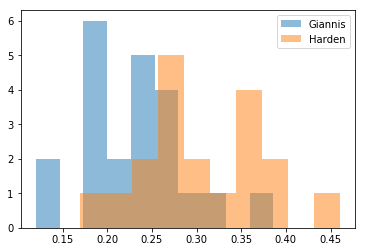

This is the standard deviation: 0.09514939522461964
Excess kurtosis of normal distribution ( should be 0):-1.216783216783217
Skewness of normal distribution ( should be 0):6.652154667543013e-16


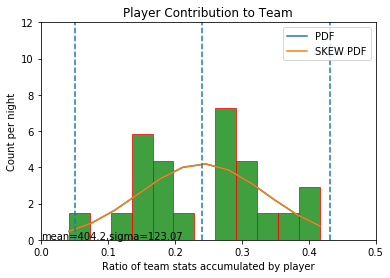

,pts,reb,ast,blk
Player,,,,
Aaron Gordon,"[0.13978494623655913, 0.2222222222222222, 0.22...","[0.061224489795918366, 0.18604651162790697, 0....","[0.10714285714285714, 0.0, 0.13636363636363635...","[0.10714285714285714, 0.0, 0.13636363636363635..."
Aaron Holiday,"[0.0, 0.0, 0.01680672268907563, 0.123711340206...","[0.0, 0.0, 0.0, 0.05660377358490566, 0.1590909...","[0.047619047619047616, 0.0, 0.0, 0.08, 0.02857...","[0.047619047619047616, 0.0, 0.0, 0.08, 0.02857..."
Abdel Nader,"[0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.04, 0.016...","[0.0, 0.0, 0.0, 0.0, 0.06382978723404255, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.034482758620689655...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.034482758620689655..."
Al Horford,"[0.07766990291262135, 0.18811881188118812, 0.0...","[0.2127659574468085, 0.2, 0.07407407407407407,...","[0.14285714285714285, 0.10526315789473684, 0.0...","[0.14285714285714285, 0.10526315789473684, 0.0..."
Al-Farouq Aminu,"[0.0390625, 0.08264462809917356, 0.03125, 0.10...","[0.1111111111111111, 0.13043478260869565, 0.34...","[0.0, 0.041666666666666664, 0.0833333333333333...","[0.0, 0.041666666666666664, 0.0833333333333333..."
Alec Burks,"[0.05, 0.05303030303030303, 0.1538461538461538...","[0.0425531914893617, 0.046511627906976744, 0.0...","[0.0, 0.03125, 0.0, 0.034482758620689655, 0.10...","[0.0, 0.03125, 0.0, 0.034482758620689655, 0.10..."
Alex Abrines,"[0.017094017094017096, 0.0234375, 0.2252252252...","[0.023255813953488372, 0.0, 0.0408163265306122...","[0.0, 0.0, 0.0, 0.058823529411764705, 0.115384...","[0.0, 0.0, 0.0, 0.058823529411764705, 0.115384..."
Alex Len,"[0.12030075187969924, 0.06306306306306306, 0.0...","[0.25, 0.12962962962962962, 0.1081081081081081...","[0.125, 0.10714285714285714, 0.0, 0.0294117647...","[0.125, 0.10714285714285714, 0.0, 0.0294117647..."
Alex Poythress,"[0.022556390977443608, 0.009009009009009009, 0...","[0.11363636363636363, 0.018518518518518517, 0....","[0.125, 0.0, 0.030303030303030304, 0.0, 0.0312...","[0.125, 0.0, 0.030303030303030304, 0.0, 0.0312..."


In [81]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats
from collections import Counter

plt.hist(player_dict_w['Giannis Antetokounmpo'],alpha=.5,label='Giannis')
plt.hist(player_dict_w['James Harden'],alpha=.5,label='Harden')
plt.legend()
plt.show()

m=player_dict_w_assist['Giannis Antetokounmpo']

# Convert list to numpy array
samples=np.array(m)
mean=np.mean(samples)
var=np.var(samples)
std=np.sqrt(var)
print("This is the standard deviation:", std)
x=np.linspace(min(samples), max(samples),12)
print("Excess kurtosis of normal distribution ( should be 0):{}".format(stats.kurtosis(x)))
print("Skewness of normal distribution ( should be 0):{}".format(stats.skew(x)))
y_pdf=stats.norm.pdf(x,mean,std)
y_skew_pdf=stats.skewnorm.pdf(x,*stats.skewnorm.fit(samples))
l1,=plt.plot(x,y_pdf, label='PDF')
l2,=plt.plot(x,y_skew_pdf, label='SKEW PDF')
# Compute histogram of Samples
n, bins,patches=plt.hist(samples,12,density=True,facecolor='g',edgecolor='red', alpha=0.75)
plt.axvline(label='Mean=404.2 ms',x=mean,linestyle='dashed')
plt.axvline(label='Mean-2sigma=158.06 ms',x=mean-2*std,linestyle='dashed')
plt.axvline(label='Mean+2sigma=650.34 ms',x=mean+2*std, linestyle='dashed')
plt.xlabel('Ratio of team stats accumulated by player')
plt.ylabel('Count per night')
plt.title('Player Contribution to Team')
# The first plt.text arguments are coordinates x,y of the plot
plt.text(0, 0.015,r'mean=404.2,sigma=123.07')
plt.legend((l1,l2),(l1.get_label(), l2.get_label()), loc='upper right')
plt.axis([0, .5, 0, 12])
plt.show()


In [124]:
player_dict_w['Giannis Antetokounmpo']
player_dict_w['James Harden']

[0.2903225806451613,
 0.2604166666666667,
 0.2857142857142857,
 0.34782608695652173,
 0.2018348623853211,
 0.2523364485981308,
 0.25757575757575757,
 0.3412698412698413,
 0.16911764705882354,
 0.24793388429752067,
 0.26126126126126126,
 0.3968253968253968,
 0.3047619047619048,
 0.46078431372549017,
 0.25735294117647056,
 0.3611111111111111,
 0.36283185840707965,
 0.3543307086614173,
 0.37962962962962965]